# Analysis of Spotify Playlists & Song Recommender

In [1]:
import numpy as np
import sys
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

from skopt.space import *
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
from sklearn import svm, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn import model_selection

## Get Connection to Spotify Account and Playlists

In [2]:
import os
# to get a client id and client secret, you have to create an app on
# https://developer.spotify.com/dashboard/ with your Spotify account
os.environ['SPOTIPY_CLIENT_ID']=''
os.environ['SPOTIPY_CLIENT_SECRET']=''
os.environ['SPOTIPY_REDIRECT_URI']= 'http://localhost/callback/' 

In [3]:
scope = "user-library-read playlist-modify-public playlist-modify-private"
username = 'INSERT_YOUR_USERNAME'
token = util.prompt_for_user_token(username,scope,redirect_uri='http://localhost/callback/')

In [4]:
def get_playlist_audio_features(username,playlist,spotify):
    '''Store selected audio features of a playlist in a dataframe'''
    track_ids = []

    results = spotify.user_playlist(username,playlist['id'],fields="tracks,next")
    tracks = results['tracks']['items']
    for i, item in enumerate(tracks):
        track_ids.append(item['track']['id'])
    
    audio_features = []
    for i in range(len(track_ids)):
        audio_features += spotify.audio_features(track_ids[i])
        
    features_list = []
    for features in audio_features:
        features_list.append([features['energy'], features['liveness'],
                              features['tempo'], features['speechiness'],
                              features['acousticness'], features['instrumentalness'],
                              features['time_signature'], features['danceability'],
                              features['key'], features['duration_ms'],
                              features['loudness'], features['valence'],
                              features['mode'], features['type'],
                              features['uri']])
    
    df = pd.DataFrame(features_list, columns=['energy', 'liveness',
                                              'tempo', 'speechiness',
                                              'acousticness', 'instrumentalness',
                                              'time_signature', 'danceability',
                                              'key', 'duration_ms', 'loudness',
                                              'valence', 'mode', 'type', 'uri'])
    

    return df


In [5]:
def get_df_playlists(username,spotify):
    '''Store all songs in one dataframe '''
    playlists = spotify.user_playlists(username)
    df = pd.DataFrame()
    for playlist in playlists['items']:
        if playlist['owner']['id'] == username:
            df_audio_features = get_playlist_audio_features(username,playlist,spotify)
            df = df.append(df_audio_features, ignore_index = True)
    df = df.drop_duplicates()
    return df

In [6]:
spotify = spotipy.Spotify(auth=token)
df = get_df_playlists(username,spotify)

## Mean and Variance of Audio Features

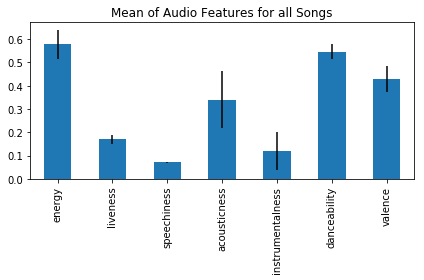

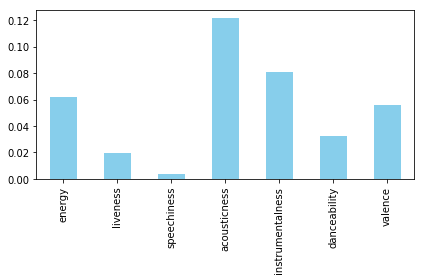

In [7]:
reduced_df = df.iloc[:, [0,1,3,4,5,7,11]]

agg_df = pd.DataFrame()
agg_df["mean"] = reduced_df.mean(axis=0)
agg_df["var"] = reduced_df.var(axis=0)

agg_df.plot(kind="bar", y="mean", legend=False, title="Mean of Audio Features for all Songs", yerr="var")
plt.tight_layout()
plt.savefig('mean_plot.png', dpi=500)
plt.show()

mean_plot = plt.imread('mean_plot.png')
 

var_reduced_df = reduced_df.var(axis=0).to_frame().T
ax = var_reduced_df.iloc[0].plot.bar(color="skyblue")
plt.tight_layout()
plt.savefig('var_plot.png')
plt.show()


## Analyze BPMs for Playlists  
**Expectation:**  
- BPM of jogging playlist should be higher than average
- BPM of work playlist should be lower than jogging playlist

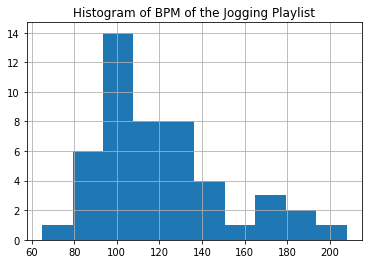

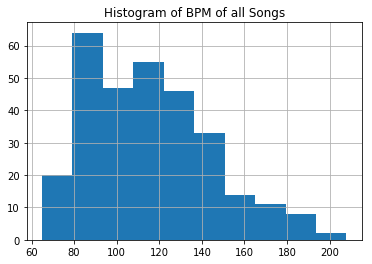

jogging mean tempo:  119.88604166666664  vs. overall mean tempo:  115.2270933333333


In [8]:
playlists = spotify.user_playlists(username)
for playlist in playlists['items']:
        if playlist['owner']['id'] == username: 
            if playlist['name'] == 'Jogging':
                jog_audio_features = get_playlist_audio_features(username,playlist,spotify)
                jog_mean_tempo = jog_audio_features['tempo'].mean()
                jog_min_tempo = jog_audio_features['tempo'].min()
                jog_max_tempo = jog_audio_features['tempo'].max()

overall_mean_tempo = df['tempo'].mean()

hist = jog_audio_features.hist(column=['tempo'])
plt.title("Histogram of BPM of the Jogging Playlist")
plt.savefig('hist_jogging_tempo.png')
hist_all = df.hist(column=['tempo'])
plt.title("Histogram of BPM of all Songs")
plt.savefig('hist_overall_tempo.png')
plt.show()

print('jogging mean tempo: ', jog_mean_tempo, ' vs. overall mean tempo: ', overall_mean_tempo)

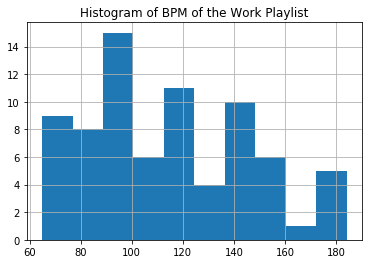

jogging mean tempo:  119.88604166666664  vs. overall mean tempo:  115.2270933333333  vs. working mean tempo:  114.68606666666666


In [9]:
playlists = spotify.user_playlists(username)
for playlist in playlists['items']:
        if playlist['owner']['id'] == username: 
            if playlist['name'] == 'Work':
                work_audio_features = get_playlist_audio_features(username,playlist,spotify)
                work_mean_tempo = work_audio_features['tempo'].mean()
                
hist = work_audio_features.hist(column=['tempo'])
plt.title("Histogram of BPM of the Work Playlist")
plt.savefig('hist_working_tempo.png')
plt.show()

print('jogging mean tempo: ', jog_mean_tempo, ' vs. overall mean tempo: ', overall_mean_tempo, 
      ' vs. working mean tempo: ', work_mean_tempo)

### Test Differences
- check normal distribution of data with Shapiro-Wilk Test $\rightarrow$ if the p-value (second value) is > 0.05, the data is normally distributed
- test differences between mean of the playlists

In [10]:
# t test
from scipy import stats
print("Shapiro-Wilk Test for Normality:")
print("- for Jogging Audio Features: ", stats.shapiro(jog_audio_features['tempo']))
print("- for Work Audio Features: ", stats.shapiro(work_audio_features['tempo']))
print("- for All Audio Features: ", stats.shapiro(df['tempo']))
# result: no violation of normality

print(" ")
print("T Test:")
print('- Jogging vs. Work: ', stats.ttest_ind(jog_audio_features['tempo'], work_audio_features['tempo'], equal_var = False))
print('- Jogging vs. All: ', stats.ttest_ind(jog_audio_features['tempo'], df['tempo'], equal_var = False))

Shapiro-Wilk Test for Normality:
- for Jogging Audio Features:  (0.908547580242157, 0.0012010324280709028)
- for Work Audio Features:  (0.9543766975402832, 0.008731386624276638)
- for All Audio Features:  (0.9638915657997131, 8.369937063434918e-07)
 
T Test:
- Jogging vs. Work:  Ttest_indResult(statistic=0.9029401459528613, pvalue=0.3686417490952336)
- Jogging vs. All:  Ttest_indResult(statistic=0.9894282945317858, pvalue=0.3263457010141897)


**Result**: Despite expecting clear differences between the (faster) jogging playlist and the (slower) work playlist, there is neither a significant difference between jogging vs. work playlist nor jogging playlist vs. all songs.  
$\Rightarrow$ _Reason_: Since the BPM can be defined variably, it might not always reflect my personal perception of the tempo of the song. 

## Train an SVM as Song Recommender

In [11]:
def optimizeOCC(X_train,X_test,model,space):
    '''Optimizes itself'''

    
    @use_named_args(space)
    def objective(**params):
        model.set_params(**params)
        model.fit(X_train)
        y_pred_test = model.predict(X_test)
        n_error_test = y_pred_test[y_pred_test == -1].size
        return n_error_test/y_pred_test.size
    
    res_gp = gp_minimize(objective, space, n_calls=150, random_state=0)

    print("Best score = %.4f" % (1-res_gp.fun))
    print("Best parameters:", res_gp.x[0], ', ', res_gp.x[1])
    
    return res_gp

###  Load and Split Data and Build Model

In [12]:
# get negative playlists
metal_playlist_uri = 'spotify:playlist:264B0D5wj2PgOr8vQvp2Ft'
death_metal = spotify.search(q='death metal', limit=50)
metal = spotify.search(q='metal', limit=50)
hard_rock = spotify.search(q='hard rock', limit=50)
punk = spotify.search(q='punk', limit=50)


playlists = [death_metal, metal, hard_rock, punk]
negative_df = pd.DataFrame()
for i in range(len(playlists)):
    track_ids = []
    tracks = playlists[i]['tracks']['items']
    for a, item in enumerate(tracks):
        track_ids.append(item['id'])
    # print('now nr. ', i)
    audio_features = []
    for j in range(len(track_ids)):
        audio_features += spotify.audio_features(track_ids[j])
    
    features_list = []
    for features in audio_features:
        features_list.append([features['energy'], features['liveness'],
                              features['tempo'], features['speechiness'],
                              features['acousticness'], features['instrumentalness'],
                              features['time_signature'], features['danceability'],
                              features['key'], features['duration_ms'],
                              features['loudness'], features['valence'],
                              features['mode'], features['type'],
                              features['uri']])

    
    n_df = pd.DataFrame(features_list, columns=['energy', 'liveness',
                                              'tempo', 'speechiness',
                                              'acousticness', 'instrumentalness',
                                              'time_signature', 'danceability',
                                              'key', 'duration_ms', 'loudness',
                                              'valence', 'mode', 'type', 'uri'])
    
    negative_df = negative_df.append(n_df, ignore_index=True)
negative_df = negative_df.iloc[:, [0,1,2,3,4,5,6,7,8,10,12]]
negative_df = negative_df.assign(label=0)

feature_df = df.iloc[:, [0,1,2,3,4,5,6,7,8,10,12]] # 11 features
feature_df = feature_df.assign(label=1)


In [13]:
X = pd.concat([negative_df,feature_df], ignore_index=True)
X = shuffle(X)
display(X)

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,loudness,mode,label
22,0.974,0.0772,182.095,0.1140,0.000670,0.001060,4,0.268,9,-2.948,1,0
33,0.932,0.2340,136.480,0.0509,0.006820,0.624000,4,0.639,5,-6.857,1,0
407,0.295,0.0929,92.073,0.0390,0.736000,0.000913,4,0.415,7,-15.334,1,1
395,0.340,0.0992,145.024,0.0295,0.349000,0.000000,4,0.352,2,-11.925,1,1
402,0.712,0.1100,114.997,0.0323,0.080200,0.000000,4,0.722,6,-6.099,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
310,0.950,0.0710,134.035,0.0559,0.000042,0.004690,4,0.492,2,-4.601,1,1
247,0.743,0.1470,100.038,0.0818,0.533000,0.000001,4,0.737,0,-6.281,0,1
51,0.362,0.0750,142.352,0.0263,0.045800,0.000006,3,0.553,4,-11.218,0,0
352,0.798,0.1500,92.207,0.0451,0.188000,0.000000,4,0.654,0,-4.084,1,1


In [14]:
y = X[X.columns[-1]]
x = X[X.columns.difference(['label'])]

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.3)

### Train and Optimize SVM

In [15]:
# use SVM as classifier 
svm = SVC(gamma='auto')

cv_score = model_selection.cross_val_score(svm, X_train, y_train, scoring='accuracy', cv=5)
print('Cross val acc: ', cv_score.mean())

space = [Categorical(['linear','rbf','sigmoid','poly'], name='kernel'),
        Integer(2, 15, name='degree'), Real(0.01, 0.99, name='gamma')] 

@use_named_args(space)
def objective(**params):
    svm.set_params(**params)
    cv_score = model_selection.cross_val_score(svm, X_train, y_train, scoring='accuracy', cv=10)
    print("CV Score: ", cv_score.mean())
    return 1-cv_score.mean()
    
# optimize SVM
res_gp = gp_minimize(objective, space, n_calls=15, random_state=7834723)

Cross val acc:  0.5600944799230163
CV Score:  0.7715732959850607
CV Score:  0.6342063492063492
CV Score:  0.5914705882352941
CV Score:  0.7886554621848739
CV Score:  0.7886554621848739
CV Score:  0.5914705882352941
CV Score:  0.5912371615312791
CV Score:  0.637063492063492
CV Score:  0.6398366013071894
CV Score:  0.5914705882352941
CV Score:  0.7886554621848739
CV Score:  0.7886554621848739
CV Score:  0.7886554621848739
CV Score:  0.7886554621848739
CV Score:  0.7886554621848739


Best score = 0.7887
Best parameters: linear ,  14 ,  0.36404328290346266


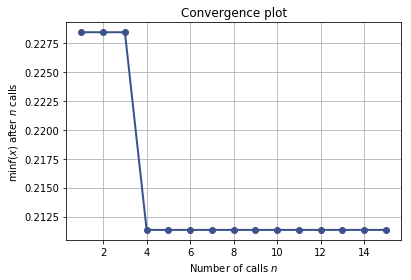

accuracy score train:  0.8085714285714286
accuracy score test:  0.8


In [16]:
print("Best score = %.4f" % (1-res_gp.fun))
print("Best parameters:", res_gp.x[0], ', ', res_gp.x[1], ', ', res_gp.x[2])

svm.set_params(kernel=res_gp.x[0],degree=res_gp.x[1],gamma=res_gp.x[2])
svm.fit(X_train,y_train)
plot_convergence(res_gp)
plt.show()
y_pred_train = svm.predict(X_train)
y_pred_test = svm.predict(X_test)


acc_train = accuracy_score(y_train, y_pred_train)
print('accuracy score train: ', acc_train)
acc_test = accuracy_score(y_test, y_pred_test)
print('accuracy score test: ', acc_test)

In [17]:
# save model
filename = 'final_model.sav'
pickle.dump(svm, open(filename, 'wb'))

Note: Songs can be predicted by the model in "predict_spotify_model.ipynb".